#### reconocimiento de cara xd xd xd

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#import pickle

In [20]:
DIR_KNOWNS = 'conocidas'
DIR_UNKNOWNS = 'desconocidas'
DIR_RESULTS = 'resultados'

In [21]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [22]:
print(mobilenet)

In [23]:
# Cargar imagen con opencv
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{NAME}'), cv2.COLOR_BGR2RGB)

In [42]:
def detect_faces(image, score_threshold=0.50):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [43]:
# Dibujar los cuadros para las caras
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

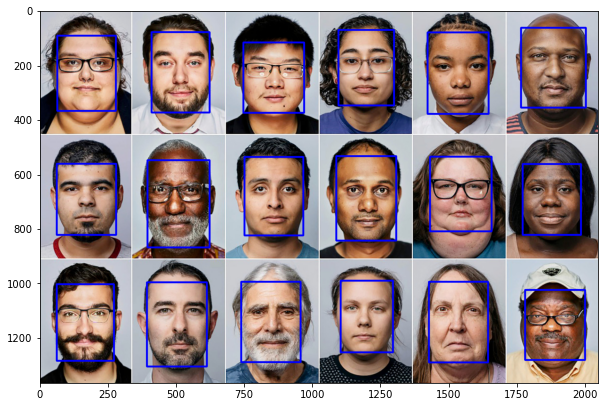

In [44]:
name = 'persona2.jpeg'
image = load_image(DIR_UNKNOWNS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,0,255))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [45]:
# Extraccion de rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

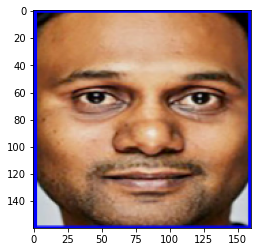

In [46]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[0])

In [47]:
# FaceNet
facenet = load_model('facenet_keras.h5')

#print(facenet.version)
print(facenet.input_shape)
print(facenet.output_shape)

(None, 160, 160, 3)
(None, 128)


In [48]:
def compute_embedding(model,face):
    #normalizamos la imagen
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [49]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[ 0.8630756  -0.7074156  -1.034046    0.08343349 -1.3313267   0.9420644
  -0.5947924  -0.21209952  1.250255   -0.6054547  -0.606603   -0.2197394
   0.05043911  0.11436975  0.36752036 -1.1350837   1.2985556   0.03798172
   0.41045865 -0.4611726   1.0290781  -0.81169295 -0.94869846 -0.86399674
   2.6544166   1.1437857   0.54855096 -0.67843056 -0.40123242 -0.20993598
   0.33805275  0.97244537  0.7586942  -0.18945229  0.41989642  0.82035434
  -0.76555693 -0.9331805  -0.8798645   0.4706034   0.02396683  1.259202
   1.4569737   0.43158537  0.801617    0.24963552 -0.8450696   1.0120956
   0.5343552  -0.43032432  2.3496609  -0.15956216 -1.2944907  -1.8971364
   2.5106573  -0.06346489  0.04983256 -0.13439164  0.7012963  -0.25757533
   0.6917103  -0.5746585   0.77900314 -0.3579701   1.1767184  -1.0944706
  -2.4412444   0.16465011 -1.284236   -1.5014342   1.0785068  -0.95719004
  -0.6298193  -1.5645539   1.093946   -0.8271741   0.20112643 -0.10360827
  -0.3938168   0.38478148  0.1549705   1.6921

In [50]:
# Embeddings referencia futura comparacion
known_embeddings = []
#se evalua los conocidos
print('Procesando rostros conocidos...')
for name in os.listdir(DIR_KNOWNS):
    if name.endswith('.jpeg'):
        print(f'   {name}')
        image = load_image(DIR_KNOWNS,name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0]))        
        
        
        

Procesando rostros conocidos...
   conosido1.jpeg
   conosido2.jpeg
   conosido3.jpeg
   conosido4.jpeg
   conosido5.jpeg


In [51]:
print(known_embeddings)

[array([[ 0.17036957,  1.6879741 , -1.5075452 , -0.12767749, -0.16335435,
        -0.92171293, -0.05681256,  1.1118387 , -1.743481  ,  0.52640843,
        -1.1795628 ,  0.19206594, -0.5711578 ,  2.7918348 ,  0.12530605,
         0.43449962,  0.2884161 , -1.8271344 , -0.7607943 ,  0.63548   ,
         0.47339848,  0.6384303 ,  0.1138921 ,  0.92738885, -0.5371342 ,
        -0.59680635, -1.1878287 ,  0.35559225,  0.03569993, -0.99732584,
        -0.5063224 ,  0.81026465, -0.5832368 ,  1.1137835 ,  0.35443133,
        -1.53583   ,  0.16294089, -0.7585633 ,  2.3398054 ,  0.33765748,
        -1.8864264 , -0.2632781 , -0.40574816, -2.308595  , -0.10882565,
        -0.32122284,  0.7914504 ,  0.42419532, -0.2844657 ,  1.1895195 ,
        -1.5822818 ,  1.8400975 , -0.88329095, -0.98624283, -0.1113954 ,
        -0.6906313 , -0.33003882,  0.5391899 ,  0.49433148,  1.2400521 ,
        -0.24391481, -0.65050286, -0.01695222, -0.65824264, -0.6778019 ,
        -0.02321267,  0.44031155,  1.953221  ,  0.

In [52]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    #compara las distancias con el umbral de las imagenes
    return distancias, list(distancias<=umbral)

In [53]:
# Reconocimientos rostros desconocidos
print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_UNKNOWNS):
    if name.endswith('.jpeg'):
        print(f'   {name}')
        image = load_image(DIR_UNKNOWNS,name)
        bboxes = detect_faces(image)
        faces = extract_faces(image,bboxes)
        
        # Por cada rostro calcular su posibildad de similitud
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(facenet,face)
            
            _, reconocimiento = compare_faces(known_embeddings,emb)
            # caras reconocidas sombrearan verde y las otras rojas
            if any(reconocimiento):
                print('     match!')
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
            
        cv2.imwrite(f'{DIR_RESULTS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Fin!')                    
            
        
        
        

Procesando imágenes desconocidas...
   conosido1.jpeg
     match!
   conosido2.jpeg
     match!
     match!
   conosido3.jpeg
     match!
   conosido4.jpeg
     match!
   conosido5.jpeg
     match!
   persona1.jpeg
   persona2.jpeg
   persona3.jpeg
   persona4.jpeg
     match!
   persona6.jpeg
   persona7.jpeg
   persona8.jpeg
¡Fin!
